## Inference model using these strategies

Each technique adds significant time cost. You may play around which combos give the best balance for your specific domain

#### CRFs and Morphological Operations

Refine boundaries and clean up noises

Use PyDenseCRF, employ dilation and erosion

#### Thresholding

Fine tune uncertain regions around boundaries

Apply threshold on logits after softmax

#### Test-Time Augmentation and Multi-Scale

Improve robustness and accuracy, reduce reliance on specific features

Apply augmentations like flipping, rotation, scaling, etc ... Then aggregate results by max/most/mean/weighted on logits/probs/classes

In [1]:
import itertools
import sys
from pathlib import Path
from typing import Literal, Sequence

import numpy as np
import torch
import torchvision
from PIL.Image import Image
from pydensecrf.utils import unary_from_softmax
from scipy.ndimage import binary_dilation, binary_erosion, gaussian_filter
from torch import Tensor, nn
from torch.nn import functional as F
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as TF
from torchvision.utils import draw_segmentation_masks

sys.path.append(str(Path("..").resolve()))
from src.datasets import resolve_metadata
from src.models import FCN_ResNet34_Weights, fcn_resnet34
from src.pipeline import forward_batch
from src.utils.transform import SegmentationTransform
from src.utils.visual import combine_images, draw_mask_on_image

In [2]:
def refine_prob_by_crf(prob: np.ndarray, image: np.ndarray | None, iter=5):
    """Apply crf on softmax class-probabilities

    Reference https://github.com/lucasb-eyer/pydensecrf/blob/master/README.md

    Args:
        prob (float array (num_classes, height, width)): Tensor after applying
            softmax to logits
        image (uint8 array (height, width, num_classes)): If `None`, color-dependent
            potentials will not be added
    """
    try:
        from pydensecrf import densecrf as dcrf  # type: ignore
    except ImportError:
        raise ImportError(
            "Package pydensecrf not found. Please check installation"
            f" on https://github.com/lucasb-eyer/pydensecrf.git"
        ) from None

    num_classes, H, W = prob.shape
    dense_crf = dcrf.DenseCRF2D(W, H, num_classes)
    unary = unary_from_softmax(prob)
    dense_crf.setUnaryEnergy(unary)

    dense_crf.addPairwiseGaussian(sxy=3, compat=3)
    if image is not None:
        dense_crf.addPairwiseBilateral(sxy=80, srgb=13, rgbim=image, compat=10)

    inferenced = dense_crf.inference(iter)
    refined_prob = np.array(inferenced).reshape(num_classes, H, W)
    return refined_prob

In [3]:
def blur_output(output: np.ndarray, std: float = 1, **kwargs) -> np.ndarray:
    """Apply Gaussian blur on each spatial dimension separately

    Args:
        output (array (num_classes, height, width)): Technically support logit and softmax
            probability
        kwargs: See `scipy.ndimage.gaussian_filter`
    """
    # https://stackoverflow.com/questions/67302611/python-gaussian-filtering-an-n-channel-image-along-only-spatial-dimensions
    sigma = (std, std, 0)
    return gaussian_filter(output, sigma, **kwargs)

In [4]:
def morph_pred(
    pred: np.ndarray, is_dilate: bool, skip_index: int | None = None, **kwargs
) -> dict[int, np.ndarray]:
    """Apply morphological operations on each channel separately

    Note that some pixels may have more than one prediction while some may have none

    Args:
        pred (int array (height, width)): prediction results
        is_dilate: use dilation if `True`, otherwise use erosion
        skip_index: process is skipped on that channel
        kwargs: See `scipy.ndimage.[binary_dilation,binary_erosion]`

    Returns:
        processed reults, mapping of class to binary array (height, width)
    """
    processed_pred: dict[int, np.ndarray] = {}
    classes = np.unique(pred).tolist()
    for c in classes:
        if c == skip_index:
            processed_pred[c] = pred == c
            continue

        binary = pred == c
        if is_dilate:
            processed_binary = binary_dilation(binary, **kwargs)
        else:
            processed_binary = binary_erosion(binary, **kwargs)
        processed_pred[c] = processed_binary

    return processed_pred

In [5]:
def threshold_prob(prob: np.ndarray, threshold=0.5) -> dict[int, np.ndarray]:
    """
    Note that some pixels may have none prediction

    Args:
        prob (float array (num_classes, height, width)): Tensor after applying
            softmax to logits
        threshold: Confidence threshold (between 0 and 1).

    Returns:
        thresholded reults, mapping of class to binary array (height, width)
    """
    pred = np.argmax(prob, axis=0)
    max_prob = np.amax(prob, axis=0)
    threshold_mask = max_prob >= threshold

    thresholded_pred: dict[int, np.ndarray] = {}
    classes = np.unique(pred).tolist()
    for c in classes:
        thresholded_pred[c] = (pred == c) & threshold_mask
    return thresholded_pred

In [6]:
weights = FCN_ResNet34_Weights.VOC2012
model = fcn_resnet34(weights=weights)
transforms = SegmentationTransform()
augment = weights.value.transforms()
dataset = VOCSegmentation(r"D:\_Dataset", image_set="val", transforms=transforms)
metadata = resolve_metadata("VOC")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
data: tuple[Tensor, Tensor] = dataset[1]
image, mask = data
model.eval().to(device)
with torch.no_grad():
    images, masks = image.unsqueeze(0), mask.unsqueeze(0)
    logits, _ = forward_batch(model, images, masks, augment, None, device)
logit = logits["out"].squeeze(0)
prob = torch.softmax(logit, 0)
pred = logit.argmax(0)

### Pure prediction

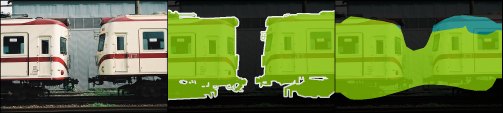

In [8]:
colors = metadata.colors
mask_overlay = draw_mask_on_image(image, mask, colors)
pred_overlay = draw_mask_on_image(image, pred, colors)
snapshot = combine_images([image, mask_overlay, pred_overlay])
snapshot_pil: Image = TF.to_pil_image(snapshot)
display(snapshot_pil.reduce(3))

### CRF

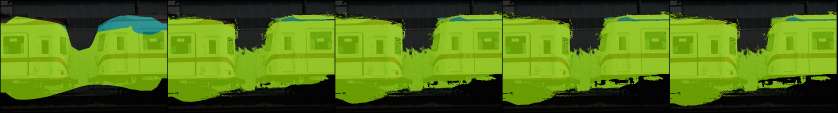

In [9]:
crf_overlays = []
crf_prob = torch.softmax(logit, dim=0).numpy(force=True)
crf_image = (
    TF.to_dtype(image, torch.uint8, scale=True)
    .permute(1, 2, 0)
    .contiguous()
    .numpy(force=True)
)
for i in range(0, 10, 2):
    crf_refined = refine_prob_by_crf(crf_prob, crf_image, iter=i)
    crf_pred = crf_refined.argmax(0)
    crf_pred_tensor = torch.tensor(crf_pred, dtype=torch.uint8)
    crf_overlay = draw_mask_on_image(image, crf_pred_tensor, colors)
    crf_overlays.append(crf_overlay)

crf_snapshot = combine_images(crf_overlays)
crf_snapshot_pil: Image = TF.to_pil_image(crf_snapshot)
display(crf_snapshot_pil.reduce(3))

### Gaussian blur

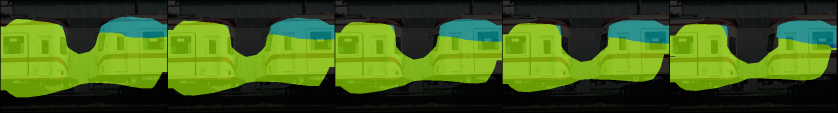

In [10]:
blur_overlays = []
for i in range(5):
    std = i / 10 + 0.5
    blur_logit = blur_output(logit.numpy(force=True), std)
    blur_pred = torch.tensor(blur_logit).argmax(0)
    blur_overlay = draw_mask_on_image(image, blur_pred, colors)
    blur_overlays.append(blur_overlay)

blur_snapshot = combine_images(blur_overlays)
blur_snapshot_pil: Image = TF.to_pil_image(blur_snapshot)
display(blur_snapshot_pil.reduce(3))

### Dilation and erosion

Dilation


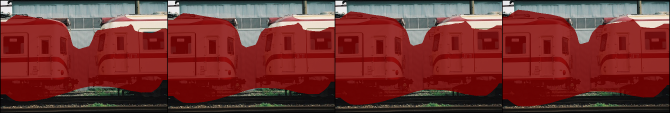

Erosion


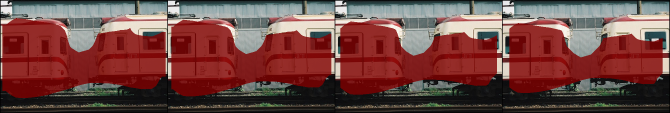

In [11]:
show_class = 19
for is_dilate in [True, False]:
    morphed_overlays = []
    for iter in range(5, 21, 5):
        morphed_pred = morph_pred(pred.numpy(force=True), is_dilate, iterations=iter)
        morphed_output = torch.tensor(morphed_pred[show_class])
        morphed_overlay = draw_segmentation_masks(
            image, morphed_output, colors=(128, 0, 0)
        )
        morphed_overlays.append(morphed_overlay)

    print("Dilation" if is_dilate else "Erosion")
    morph_snapshot = combine_images(morphed_overlays)
    morph_snapshot_pil: Image = TF.to_pil_image(morph_snapshot)
    display(morph_snapshot_pil.reduce(3))

### Threshold

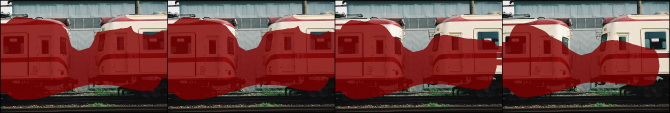

In [12]:
show_class = 19
threshold_overlays = []
for i in range(1, 5):
    th = i / 5
    threshold_pred = threshold_prob(prob.numpy(force=True), th)
    threshold_output = torch.tensor(threshold_pred[show_class])
    threshold_overlay = draw_segmentation_masks(
        image, threshold_output, colors=(128, 0, 0)
    )
    threshold_overlays.append(threshold_overlay)

threshold_snapshot = combine_images(threshold_overlays)
threshold_snapshot_pil: Image = TF.to_pil_image(threshold_snapshot)
display(threshold_snapshot_pil.reduce(3))

### Augmentation

In [13]:
@torch.no_grad()
def inference_with_augmentations(
    model: nn.Module,
    images: Tensor,
    scales: Sequence[float] = (1,),
    fliph=False,
    flipv=False,
    rotations: Sequence[float] = (0,),
    iter_product=False,
) -> Tensor:
    """
    Args:
        images: Images after applying any preliminary augmentations
        iter_product: If `True`, all combinations of the augmentations will be tested.

    Returns:
        logits (Tensor (num_combos, batch_size, num_classes, height, width)):
            inference results of all combo
    """
    hflips = [False, True] if fliph else [True]
    vflips = [False, True] if flipv else [True]
    augment_combo = []
    if iter_product:
        augment_combo = itertools.product(scales, hflips, vflips, rotations)
    else:
        augment_combo += [(s, False, False, 0) for s in scales]
        augment_combo += [(1, h, False, 0) for h in hflips]
        augment_combo += [(1, False, v, 0) for v in vflips]
        augment_combo += [(1, False, False, r) for r in rotations]

    results: list[Tensor] = []
    image_size = images.shape[2:]
    for scale, hflip, vflip, rotation in augment_combo:
        # apply augmentation
        augmented_images = images.clone().detach()
        augmented_images = F.interpolate(
            augmented_images, scale_factor=scale, mode="bilinear"
        )
        if hflip:
            augmented_images = TF.horizontal_flip(augmented_images)
        if vflip:
            augmented_images = TF.vertical_flip(augmented_images)
        augmented_images = TF.rotate(augmented_images, rotation)

        # reverse augmentation except resizing back
        logits: Tensor = model(images)["out"]
        logits = F.interpolate(logits, image_size, mode="bilinear")
        if hflip:
            logits = TF.horizontal_flip(logits)
        if vflip:
            logits = TF.vertical_flip(logits)
        logits = TF.rotate(logits, -rotation)
        results.append(logits)

    return torch.stack(results)

In [14]:
def aggregate_outputs(
    outputs: Tensor,
    method: Literal["mode", "max", "min", "mean"],
) -> Tensor:
    """Aggregate results of logits, softmax or predictions

    Usually, apply max/mean on logits or most on predictions

    Args:
        outputs (Tensor (num_combos, batch_size, ?, height, width)): can be
            logits, softmax or predictions

    Returns:
        results (Tensor (batch_size, ?, height, width)): aggregation
    """
    match method:
        case "mode":
            return torch.mode(outputs, dim=0).values
        case "max":
            return torch.max(outputs, dim=0).values
        case "min":
            return torch.min(outputs, dim=0).values
        case "mean":
            return torch.mean(outputs, dim=0)

In [15]:
prelim_images, _ = augment(images.to(device), None)
augmented_logits = inference_with_augmentations(
    model,
    prelim_images,
    (0.5, 0.75, 1, 1.25, 1.5),
    True,
    False,
    (-30, 0, 30),
    iter_product=True,
)
print(prelim_images.shape)
aggregated_logits = aggregate_outputs(augmented_logits, "mean")
print(aggregated_logits.shape)

torch.Size([1, 3, 335, 500])
torch.Size([1, 21, 335, 500])
